I realized that doing it daigonally doesn't work for the test set, but I figured out a way to do it horizontally which should be clear as well (I think). Let's try and implement that

In [1]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [2]:
data = jnp.load('u_train.npy')
baseline = jnp.load('K_baseline.npy')
diagonal = jnp.load('K_diagonal.npy')

In [3]:
gram = jnp.dot(data, data.T)
sigma_i = 0.4
sigma_r = 0.9
sigma_b = 0.4
n_samples = gram.shape[0]

In [4]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) 
    return 2 / jnp.pi * jnp.arcsin(z)

In [55]:
def update_fn(sigma_i, sigma_r, sigma_b, kernel, uu):
    def update(k_prev, inputs):
        gram, vv = inputs
        uv = sigma_i**2 * gram + sigma_r**2 * k_prev + sigma_b**2
        k = kernel(uv, uu, vv)
        k = jnp.concatenate([jnp.zeros((1, )), k[:-1]])
        return k, k
    return update

def diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel):
    def update_fn(k_prev, gram_idx):
        uv = sigma_i ** 2 * gram_idx + sigma_r **2 * k_prev + sigma_b**2
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

In [56]:
# Getting diagonal results
k_diagonal = jnp.concatenate([jnp.zeros(1, ), jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, sigma_b, erf_kernel), 0.0, jnp.diag(gram))[1]])[:-1]
u_dot_u = sigma_i**2 * jnp.diag(gram) + sigma_r**2 * k_diagonal + sigma_b**2

In [57]:
k_init = jnp.zeros((n_samples, ))
final, horizontal = jax.lax.scan(update_fn(sigma_i, sigma_r, sigma_b, erf_kernel, u_dot_u), k_init, (gram, u_dot_u))

In [58]:
jnp.allclose(jnp.diag(diagonal)[:-1], k_diagonal[1:])

DeviceArray(True, dtype=bool)

In [59]:
jnp.allclose(jnp.diag(horizontal[:-1, 1:]), k_diagonal[1:])

DeviceArray(True, dtype=bool)

Okay so those are close, thats good.

In [60]:
horizontal = horizontal[:-1, 1:]

How symmetric are we?

(0.0, 1000.0)

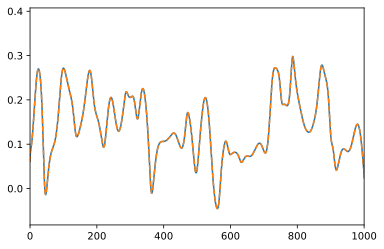

In [36]:
diag = 3000
plt.plot(jnp.diag(horizontal, k=-diag))
plt.plot(jnp.diag(horizontal, k=diag), '--')
plt.xlim([0, 1000])

In [39]:
jnp.allclose(horizontal, horizontal.T)

DeviceArray(True, dtype=bool)

how close are we too the diagonal approach:

(5000.0, 8000.0)

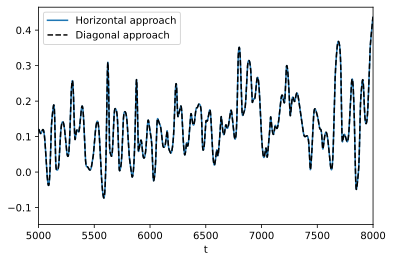

In [40]:
idx = 8000
plt.plot(horizontal[idx, :], label='Horizontal approach')
plt.plot(diagonal[idx, :], 'k--', label='Diagonal approach')
plt.xlabel('t')
plt.legend()

plt.xlim([5000, 8000])

In [45]:
jnp.allclose(horizontal, diagonal[:-1, :-1])

DeviceArray(False, dtype=bool)

In [50]:
jnp.max(jnp.abs(horizontal - diagonal[:-1, :-1]))

DeviceArray(2.682209e-07, dtype=float32)

YEAAAHHHH THEYRE THE SAME.|

Now lets code it up nicely:

In [3]:
def erf_kernel(uv, uu, vv):
    z = 2 * uv / jnp.sqrt((1 + 2 * uu)*(1 + 2 * vv)) 
    return 2 / jnp.pi * jnp.arcsin(z)

def update_fn(sigma_i, sigma_r, sigma_b, kernel, uu):
    def update(k_prev, inputs):
        gram, vv = inputs
        uv = sigma_i**2 * gram + sigma_r**2 * k_prev + sigma_b**2
        k = kernel(uv, uu, vv)
        k = jnp.concatenate([jnp.zeros((1, )), k[:-1]])
        return k, k
    return update

def diagonal_update_fn(sigma_i, sigma_r, sigma_b, kernel):
    def update_fn(k_prev, gram_idx):
        uv = sigma_i ** 2 * gram_idx + sigma_r **2 * k_prev + sigma_b**2
        k = kernel(uv, uv, uv)
        return k, k
    return update_fn

def recurrent_kernel(kernel_fn, sigma_i, sigma_r, sigma_b, data):
    n_samples = 
    gram = jnp.dot(data, data.T)
    
    # Getting diagonal results
    k_diagonal = jnp.concatenate([jnp.zeros(1, ), jax.lax.scan(diagonal_update_fn(sigma_i, sigma_r, sigma_b, erf_kernel), 0.0, jnp.diag(gram))[1]])[:-1]
    u_dot_u = sigma_i**2 * jnp.diag(gram) + sigma_r**2 * k_diagonal + sigma_b**2
    
    k_init = jnp.zeros((n_samples, ))
    K_recurrent = jax.lax.scan(update_fn(sigma_i, sigma_r, sigma_b, erf_kernel, u_dot_u), k_init, (gram, u_dot_u))[1]
    return K_recurrent[:-1, 1:]

In [5]:
sigma_i = 0.4
sigma_r = 0.9
sigma_b = 0.4

In [6]:
f = jax.jit(recurrent_kernel, static_argnums=(0, ))
K_recurrent = f(erf_kernel, sigma_i, sigma_r, sigma_b, data) # compiling

NameError: name 'n_samples' is not defined

In [6]:
%%timeit
f(erf_kernel, sigma_i, sigma_r, sigma_b, data).block_until_ready()

175 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
jnp.max(jnp.abs(diagonal[:-1, :-1] - K_recurrent))

DeviceArray(0., dtype=float32)

In [9]:
jnp.save("K_horizontal_baseline.npy", K_recurrent)